# Machine Learning
We apply a Random Forest classifier to our timelag and correlation calculations over the whole AR.

In [1]:
import os
import sys

import numpy as np
from scipy.interpolate import splev
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.map import Map,GenericMap
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import dask
import distributed
#from dask_ml.model_selection import RandomizedSearchCV
#from dask_ml.model_selection import train_test_split as dask_train_test_split

from synthesizAR.instruments import InstrumentSDOAIA

sys.path.append('../paper/python/')
from formatting import get_figsize,heating_palette,qualitative_palette,heating_cmap

import warnings
warnings.filterwarnings('ignore',category=UserWarning,)

%matplotlib inline

## Data Prep and Import
First, we need to import all of our timelag and correlation data, both modeled and observed, into data matrices, $X$, $Y$, and $X_{obs}$

In [2]:
heating = ['high_frequency', 'intermediate_frequency', 'low_frequency',]
channels = [94,131,171,193,211,335]
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]
correlation_threshold = 0.1

### Model
First we need to load the training data from our model. This includes the EM slopes, timelags, and cross-correlations.

In [3]:
file_format = '../paper/data/{}/{}_{}_{}.fits'

We want to exclude correlations $<0.1$ and NaN EM slopes from our training data set. We'll create a composite mask over the whole AR for these criteria.

In [4]:
# Correlation
all_correlations = np.stack([Map(file_format.format(h,'correlation',*cp)).data for h in heating for cp in channel_pairs])

In [5]:
correlation_mask = (all_correlations < correlation_threshold).any(axis=0,)

In [6]:
# EM Slopes
all_slopes = np.stack([Map('../paper/data/{}/em_slope.fits'.format(h)).data for h in heating])

In [7]:
slope_mask = np.isnan(all_slopes).any(axis=0)

In [9]:
bad_pixels = np.stack((correlation_mask,slope_mask),).any(axis=0)

Now that we know which pixels to exclude, we'll create separate data matrices for the timelags, cross-correlations, and emission measure slopes.

In [10]:
# Timelags
X_timelag = np.stack(
    [np.hstack(
        [Map(file_format.format(h,'timelag',*cp)).data[np.where(~bad_pixels)].flatten() for h in heating])
     for cp in channel_pairs],
    axis=1
)

In [11]:
# Correlations
X_correlation = np.stack(
    [np.hstack(
        [Map(file_format.format(h,'correlation',*cp)).data[np.where(~bad_pixels)].flatten() for h in heating])
     for cp in channel_pairs],
    axis=1
)

In [12]:
# Slopes
X_slope = np.hstack([
    Map('../paper/data/{}/em_slope.fits'.format(h)).data[np.where(~bad_pixels)].flatten() for h in heating
])
X_slope = X_slope[:,np.newaxis]

Finally, get all of the labels associated with the heating and encode each label with a numerical value in order to apply our classification method. We use the following scheme,

* High frequency $\to$ 0
* Intermediate frequency $\to$ 1
* Low frequency $\to$ 2

In [13]:
le = LabelEncoder()
le.fit(heating)
Y = le.transform(np.hstack([np.where(~bad_pixels)[0].shape[0]*[h] for h in heating]))

### Observations

Next, we import the observational data for the timelags, cross-correlations, and EM slopes. Again, we need to create a mask for invalid cross-correlations and EM slopes.

In [15]:
all_correlations = np.stack([Map(file_format.format('observations','correlation',*cp)).data for cp in channel_pairs])
correlation_mask = (all_correlations < correlation_threshold).any(axis=0,)
slope_mask = np.isnan(Map('../paper/data/observations/em_slope.fits').data)
bad_pixels = np.stack((correlation_mask,slope_mask),).any(axis=0)

Create separate matrices for timelags, cross-correlations, and slopes.

In [16]:
# Timelags
X_observation_timelag = np.stack(
    [Map(file_format.format('observations','timelag',*cp)).data[np.where(~bad_pixels)].flatten() for cp in channel_pairs],
    axis=1
)
# Correlations
X_observation_correlation = np.stack(
    [Map(file_format.format('observations','correlation',*cp)).data[np.where(~bad_pixels)].flatten() for cp in channel_pairs],
    axis=1
)
# Slopes
X_observation_slope = Map('../paper/data/observations/em_slope.fits').data[np.where(~bad_pixels)].flatten()
X_observation_slope = X_observation_slope[:,np.newaxis]

In [3]:
def prep_data(top_dir, channel_pairs, heating, correlation_threshold=0.1):
    file_format = os.path.join(top_dir, '{}', '{}_{}_{}.fits')
    ### Model ###
    # Create Mask
    all_correlations = np.stack([Map(file_format.format(h,'correlation',*cp)).data for h in heating for cp in channel_pairs])
    correlation_mask = (all_correlations < correlation_threshold).any(axis=0,)
    all_slopes = np.stack([Map(os.path.join(top_dir, f'{h}', 'em_slope.fits')).data for h in heating])
    slope_mask = np.isnan(all_slopes).any(axis=0)
    bad_pixels = np.stack((correlation_mask, slope_mask),).any(axis=0)
    # Load all three datasets
    X_timelag = np.stack(
        [np.hstack([Map(file_format.format(h,'timelag',*cp)).data[np.where(~bad_pixels)].flatten() for h in heating])
         for cp in channel_pairs],
        axis=1)
    X_correlation = np.stack(
        [np.hstack([Map(file_format.format(h,'correlation',*cp)).data[np.where(~bad_pixels)].flatten() for h in heating])
         for cp in channel_pairs],
        axis=1)
    X_slope = np.hstack([
        Map('../paper/data/{}/em_slope.fits'.format(h)).data[np.where(~bad_pixels)].flatten() for h in heating])
    X_slope = X_slope[:,np.newaxis]
    X = np.hstack((X_timelag, X_correlation, X_slope))
    # Load labels
    Y = np.hstack([np.where(~bad_pixels)[0].shape[0]*[h] for h in heating])
    ### Observation ###
    # Create Mask
    all_correlations = np.stack([Map(file_format.format('observations', 'correlation', *cp)).data for cp in channel_pairs])
    correlation_mask = (all_correlations < correlation_threshold).any(axis=0,)
    slope_mask = np.isnan(Map(os.path.join(top_dir, 'observations', 'em_slope.fits')).data)
    bad_pixels = np.stack((correlation_mask, slope_mask),).any(axis=0)
    # Load all three datasets
    X_timelag = np.stack(
        [Map(file_format.format('observations','timelag',*cp)).data[np.where(~bad_pixels)].flatten() for cp in channel_pairs],
        axis=1
    )
    X_correlation = np.stack(
        [Map(file_format.format('observations','correlation',*cp)).data[np.where(~bad_pixels)].flatten() for cp in channel_pairs],
        axis=1
    )
    X_slope = Map('../paper/data/observations/em_slope.fits').data[np.where(~bad_pixels)].flatten()
    X_slope = X_slope[:,np.newaxis]
    X_observation = np.hstack((X_timelag, X_correlation, X_slope))
    
    return X, Y, X_observation, bad_pixels

In [4]:
X, Y, X_observation, bad_pixels = prep_data('../paper/data/', channel_pairs, heating, correlation_threshold=correlation_threshold)

## Classification

Now, we train a Random Forest classifier on our model results.

In [5]:
def classify_ar(classifier_params, X_model, Y_model, X_observation, bad_pixels, **kwargs):
    # Encode labels
    le = LabelEncoder()
    le.fit(Y_model);
    Y_model = le.transform(Y_model)
    # Scale and split training data
    X_scaled = scale(X_model, axis=0, with_mean=True, with_std=True,)
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_model, test_size=kwargs.get('test_size', 0.33))
    # Scale observed data
    X_observation_scaled = scale(X_observation, axis=0, with_mean=True, with_std=True)
    # Fit classifier
    clf = RandomForestClassifier(**classifier_params)
    clf.fit(X_train, Y_train)
    print(f'Test error = {1. - clf.score(X_test, Y_test)}')
    # Classify observations
    Y_observation = clf.predict(X_observation_scaled)
    Y_observation_prob = clf.predict_proba(X_observation_scaled)
    # Frequency map
    data = np.empty(bad_pixels.shape)
    data[bad_pixels] = np.nan
    data[~bad_pixels] = Y_observation
    frequency_map = data.copy()
    # Probability maps
    probability_maps = {}
    for i,c in enumerate(le.inverse_transform(clf.classes_)):
        data = np.empty(bad_pixels.shape)
        data[bad_pixels] = np.nan
        data[~bad_pixels] = Y_observation_prob[:, i]
        probability_maps[c] = data.copy()
        
    return frequency_map, probability_maps, clf

To start off with, we'll choose a set of parameters that sound the best and we'll run the classifier. Ideally, we should do some hyper parameter tuning here.

In [6]:
rf_options = {
    'n_estimators': 100,
    'max_features': 'sqrt',
    'criterion': 'gini',
    'max_depth': 25,
    'min_samples_leaf': 1,
    'bootstrap': True,
    'oob_score': True,
}

In [7]:
frequency_maps = {}
probability_maps = {}

In [8]:
meta = Map('../paper/data/observations/timelag_171_131.fits').meta

### EM Slope

In [10]:
f_map,p_maps,clf = classify_ar(rf_options, X[:,-1:], Y, X_observation[:,-1:], bad_pixels,)
frequency_maps['a'] = f_map
probability_maps['a'] = p_maps

Test error = 0.2583091319780574


### Timelags + Cross-Correlation

In [12]:
f_map,p_maps,_ = classify_ar(rf_options, X[:,:-1], Y, X_observation[:,:-1], bad_pixels)
frequency_maps['b'] = f_map
probability_maps['b'] = p_maps

Test error = 0.03836721523071962


### Timelags + Cross-correlation + EM Slope

In [14]:
f_map,p_maps,clf = classify_ar(rf_options, X, Y, X_observation, bad_pixels)
frequency_maps['c'] = f_map
probability_maps['c'] = p_maps

Test error = 0.02775088738302678


### Comparing the Cases

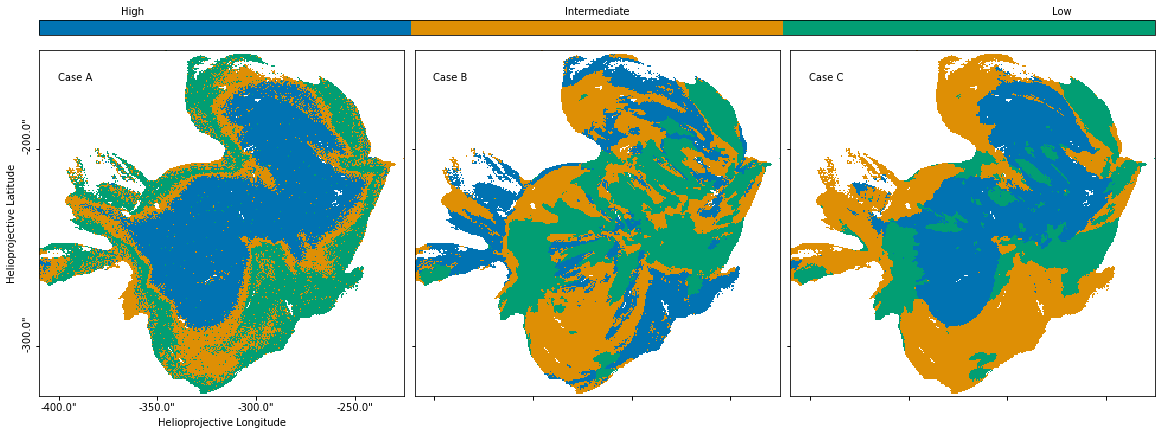

In [17]:
fig = plt.figure(figsize=(20,7))
cax = fig.add_axes([0.125, 0.875, 0.775, 0.03])
plt.subplots_adjust(wspace=0.03)
for i,c in enumerate(('a','b','c')):
    m = GenericMap(frequency_maps[c],meta)
    m = m.submap(SkyCoord(Tx=-410*u.arcsec,Ty=-325*u.arcsec,frame=m.coordinate_frame),
                 SkyCoord(Tx=-225*u.arcsec,Ty=-150*u.arcsec,frame=m.coordinate_frame))
    ax = fig.add_subplot(1,3,i+1,projection=m)
    im = m.plot(
        axes=ax,
        title=False,
        annotate=False,
        vmin=-0.5,
        vmax=2.5,
        cmap=heating_cmap()
    )
    ax.grid(alpha=0)
    # Axes and ticks
    lon, lat = ax.coords
    if i == 0:
        lon.set_axislabel('Helioprojective Longitude',)
        lat.set_axislabel('Helioprojective Latitude',)
        lat.set_ticklabel(rotation='vertical')
    else:
        lon.set_ticklabel_visible(False)
        lat.set_ticklabel_visible(False)
    lon.set_ticks(number=4)
    lat.set_ticks(number=2)
    xtext,ytext = m.world_to_pixel(SkyCoord(-400*u.arcsec,-165*u.arcsec,frame=m.coordinate_frame))
    xtext,ytext = int(xtext.value), int(ytext.value)
    ax.text(xtext, ytext, f'Case {c.capitalize()}', color='k', fontsize=plt.rcParams['axes.labelsize'])
# Colorbar
cbar = fig.colorbar(im, cax=cax,orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
cbar.set_ticks([-0.25,1,2.25])
cbar.ax.set_xticklabels([h.split('_')[0].capitalize() for h in heating],)
cbar.ax.tick_params(axis='x',which='both',length=0)

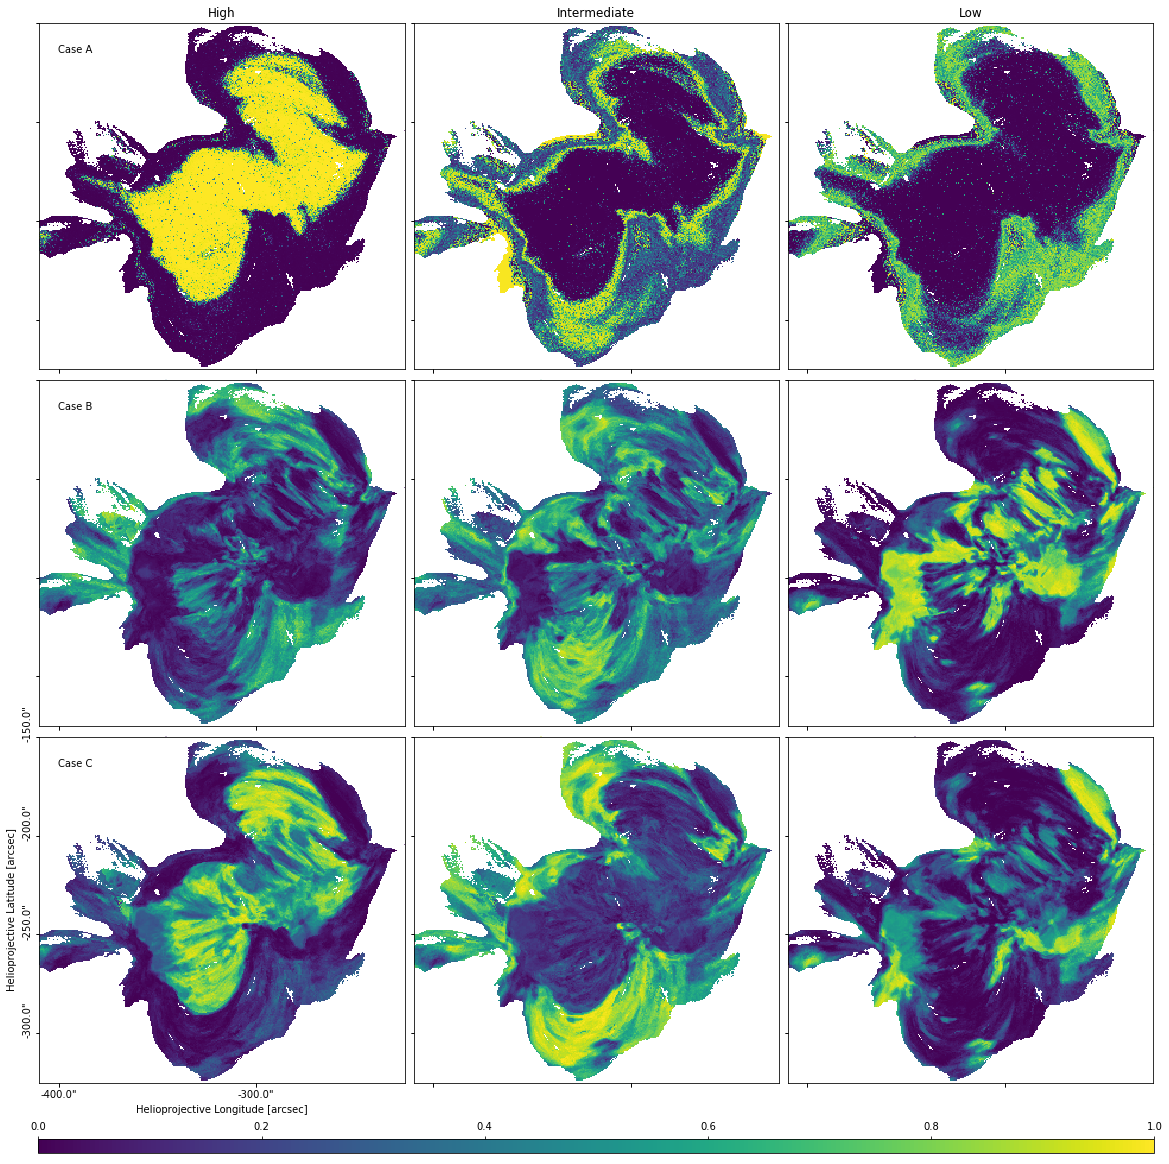

In [18]:
fig = plt.figure(figsize=(20,19.5))
cax = fig.add_axes([0.125, 0.075, 0.775, 0.01])
plt.subplots_adjust(wspace=0.03,hspace=0.03)
for j,c in enumerate(('a','b','c')):
    for i,h in enumerate(heating):
        m = GenericMap(probability_maps[c][h], meta)
        m = m.submap(SkyCoord(Tx=-410*u.arcsec,Ty=-325*u.arcsec,frame=m.coordinate_frame),
                     SkyCoord(Tx=-225*u.arcsec,Ty=-150*u.arcsec,frame=m.coordinate_frame))
        ax = fig.add_subplot(3,3,3*j+i+1, projection=m)
        im = m.plot(axes=ax,
                    annotate=False,
                    title=False,
                    vmin=0,
                    vmax=1,
                    cmap='viridis',
                   )
        ax.grid(alpha=0)
        lon,lat = ax.coords
        lon.set_ticks(number=3)
        lat.set_ticks(number=3)
        if i == 0 and j==2:
            lon.set_axislabel('Helioprojective Longitude [arcsec]',)
            lat.set_axislabel('Helioprojective Latitude [arcsec]', )
            lat.set_ticklabel(rotation='vertical')
        else:
            lat.set_ticklabel_visible(False)
            lon.set_ticklabel_visible(False)
        if i == 0:
            xtext,ytext = m.world_to_pixel(SkyCoord(-400*u.arcsec,-165*u.arcsec,frame=m.coordinate_frame))
            xtext,ytext = int(xtext.value), int(ytext.value)
            ax.text(xtext, ytext, f'Case {c.capitalize()}', color='k', fontsize=plt.rcParams['axes.labelsize'])
        if j == 0:
            ax.set_title(h.split('_')[0].capitalize(),)
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
plt.subplots_adjust(wspace=0.02)

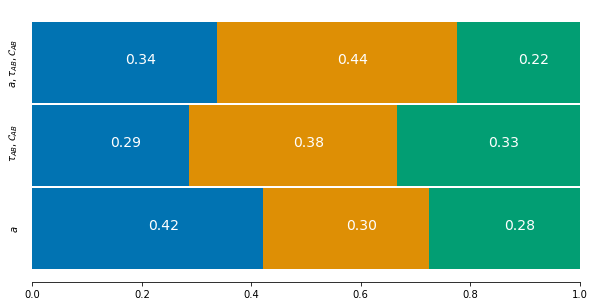

In [188]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
height=1.0
for i,c in enumerate(('a', 'b', 'c')):
    d = frequency_maps[c].data[~np.isnan(frequency_maps[c].data)].flatten()
    x0 = d[d == 0].shape[0]/d.shape[0]
    x1 = d[d == 1].shape[0]/d.shape[0]
    x2 = d[d == 2].shape[0]/d.shape[0]
    y = i*1.025
    ax.barh(y,x0,color=heating_palette()[0],height=height,edgecolor=None)
    ax.text(x0/2, y, f'{x0:.2f}',color='w',fontsize=14)
    ax.barh(y,x1,left=x0,color=heating_palette()[1],height=height,edgecolor=None)
    ax.text((2*x0+x1)/2, y, f'{x1:.2f}',color='w',fontsize=14)
    ax.barh(y,x2,left=x0+x1,color=heating_palette()[2],height=height,edgecolor=None)
    ax.text((2*x0+2*x1+x2)/2, y, f'{x2:.2f}',color='w',fontsize=14)
#Labels, Ticks, etc
ax.set_xlim(-0.01,1.01)
ax.set_yticks([0,1.25,2.3,],)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['bottom'].set_bounds(0,1)
#ax.set_xticks([])
plt.tick_params(axis='y',which='both',left=False)
ax.set_yticklabels((r'$a$', r'$\tau_{AB},\mathcal{C}_{AB}$', r'$a,\tau_{AB},\mathcal{C}_{AB}$', ),rotation='vertical');

What if we drop every parameter but the slope and the 211-193 Å cross-correlation?

In [189]:
f_map,p_maps,clf = classify_ar(
    rf_options,
    np.hstack((X_timelag[:,[i for i in range(15) if i != 11]], X_correlation[:,[i for i in range(15) if i != 11]],),),
    Y,
    np.hstack((X_observation_timelag[:,[i for i in range(15) if i != 11]], X_observation_correlation[:,[i for i in range(15) if i != 11]],),)
)

Test error = 0.04824136818328495


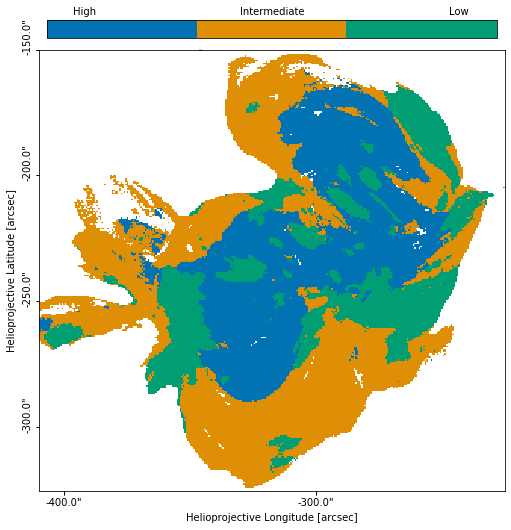

In [190]:
fig = plt.figure(figsize=get_figsize(wf=1.85,))
cax = fig.add_axes([0.275, 0.9, 0.475, 0.03])
m = frequency_maps['c'].submap(
    SkyCoord(Tx=-410*u.arcsec,Ty=-325*u.arcsec,frame=frequency_maps['c'].coordinate_frame),
    SkyCoord(Tx=-225*u.arcsec,Ty=-150*u.arcsec,frame=frequency_maps['c'].coordinate_frame)
)
ax = fig.gca(projection=m)
im = m.plot(
    axes=ax,
    title=False,
    annotate=False,
    vmin=-0.5,
    vmax=2.5,
    cmap=heating_cmap()
)
ax.grid(alpha=0)
# Axes and ticks
lon, lat = ax.coords
lat.set_ticklabel(rotation='vertical')
lon.set_axislabel('Helioprojective Longitude [arcsec]',)
lat.set_axislabel('Helioprojective Latitude [arcsec]',)
lon.set_ticks(number=3)
lat.set_ticks(number=3)
# Colorbar
cbar = fig.colorbar(im, cax=cax,orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
cbar.set_ticks([-0.25,1,2.25])
cbar.ax.set_xticklabels([h.split('_')[0].capitalize() for h in heating],)
cbar.ax.tick_params(axis='x',which='both',length=0)

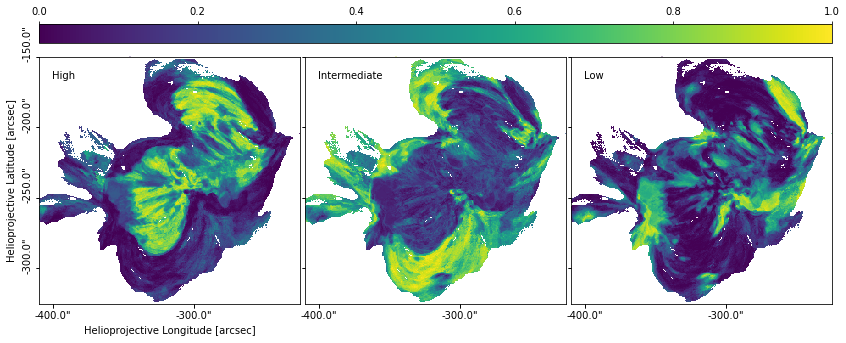

In [191]:
fig = plt.figure(figsize=get_figsize(wf=2,))
cax = fig.add_axes([0.125, 0.72, 0.775, 0.03])
for i,h in enumerate(heating):
    m = probability_maps['c'][h]
    m = m.submap(SkyCoord(Tx=-410*u.arcsec,Ty=-325*u.arcsec,frame=m.coordinate_frame),
                 SkyCoord(Tx=-225*u.arcsec,Ty=-150*u.arcsec,frame=m.coordinate_frame))
    ax = fig.add_subplot(1,3,i+1, projection=m)
    im = m.plot(axes=ax,
                annotate=False,
                title=False,
                vmin=0,
                vmax=1,
                cmap='viridis',
               )
    ax.grid(alpha=0)
    lon,lat = ax.coords
    lon.set_ticks(number=3)
    lat.set_ticks(number=3)
    if i > 0:
        lat.set_ticklabel_visible(False)
    else:
        lat.set_ticklabel(rotation='vertical')
    if i == 0:
        lon.set_axislabel('Helioprojective Longitude [arcsec]',)
        lat.set_axislabel('Helioprojective Latitude [arcsec]', )
    xtext,ytext = m.world_to_pixel(SkyCoord(-400*u.arcsec,-165*u.arcsec,frame=m.coordinate_frame))
    xtext,ytext = int(xtext.value), int(ytext.value)
    ax.text(xtext, ytext, h.split('_')[0].capitalize(), color='k', fontsize=plt.rcParams['axes.labelsize'])
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
plt.subplots_adjust(wspace=0.02)

## Figure Code
Make sure not to remove this

Finally, make plots of both the frequency label as well as the probabilites of each class.

For this combined case, let's plot the importance of each of the features in performing the classification in each pixel

Text(0, 0.5, 'Feature Importance')

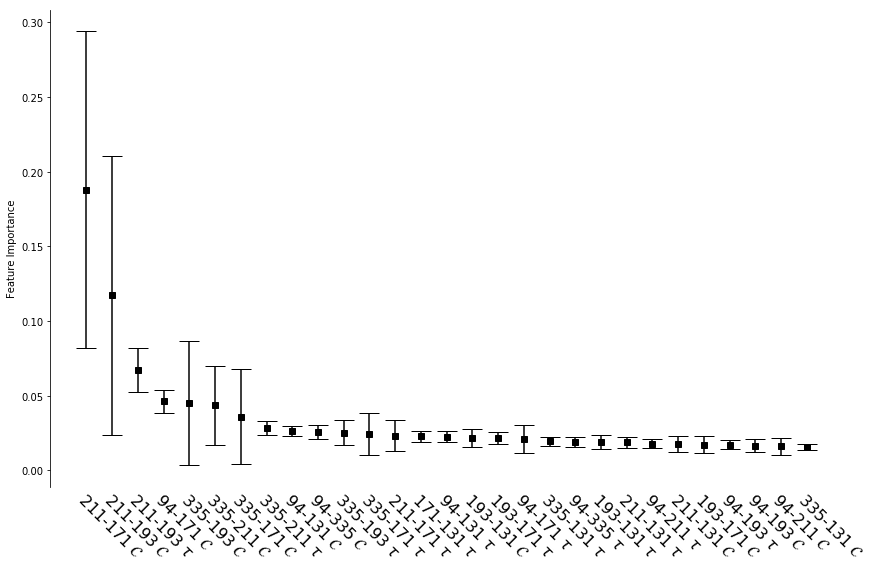

In [77]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
est_std = np.std([t.feature_importances_ for t in clf.estimators_], axis=0)
all_labs = (
    ['{}-{} $\\tau$'.format(*cp) for cp in channel_pairs] +
    ['{}-{} $\mathcal{{C}}$'.format(*cp) for cp in channel_pairs] +
    ['a']
)
indices = indices[:]
fig = plt.figure(figsize=get_figsize(wf=2))
ax = fig.gca()
ax.errorbar(range(indices.shape[0]), importances[indices], yerr=est_std[indices], color='k', ls='', marker='s',capsize=10)
#ax.set_ylim(0,0.2)
#ax.set_yscale('log')
ax.set_xticks(range(indices.shape[0]),);
ax.set_xticklabels(np.array(all_labs)[indices],fontsize=16);
plt.setp(ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode='anchor');
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_bounds(ax.get_ylim()[1], ax.get_ylim()[-2])
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('Feature Importance')
#ax.set_yticks(ax.get_yticks()[1:-1:2]);

## Cross-validation via Random Grid Search

In [15]:
grid_parameters = {
    'n_estimators': [10, 100, 200],
    'max_features': ['sqrt', 1/3],
    'max_depth': [10, 20, 50],
    'min_samples_leaf': [1],
    'criterion': ['entropy','gini'],
    'bootstrap': [True,],
    'oob_score': [True, False],
}

In [16]:
rf = RandomForestClassifier()

In [17]:
client = distributed.Client()

In [19]:
clf_rcv = RandomizedSearchCV(rf, grid_parameters, n_iter=100,)

In [32]:
X_train_dask, X_test_dask, Y_train_dask, Y_test_dask = dask_train_test_split(
    dask.array.from_array(X_scaled,chunks=X_scaled.shape),
    dask.array.from_array(Y_encoded,chunks=Y_encoded.shape),
    test_size=0.33,
)

In [33]:
clf_rcv.fit(X_train_dask, Y_train_dask)

RandomizedSearchCV(cache_cv=True, cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 100, 200], 'max_features': ['sqrt', 0.3333333333333333], 'max_depth': [10, 20, 50], 'min_samples_leaf': [1], 'criterion': ['entropy', 'gini'], 'bootstrap': [True], 'oob_score': [True, False]},
          random_state=None, refit=True, return_train_score='warn',
          scheduler=None, scoring=None)

In [38]:
clf_rcv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)